# Code Self-Made Survey

This file contains the main code for the analysis of the self-made survey. 

In [1]:
# import required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import networkx as nx
from node2vec import Node2Vec

# load the datasets
df0 = pd.read_csv('Kenntnisse und Einstellungen im Finanzbereich.csv')
df0.drop(columns='Timestamp',inplace=True)
df1 = pd.read_csv('Attitudes and Knowledge Regarding Finance.csv')
df1.drop(columns='Timestamp',inplace=True)

## Merge the English and German datasets

In [2]:
df0.columns

Index(['Alter', 'Geschlecht', 'Nationalität',
       'Was entspricht Ihrer zuletzt abgeschlossenen Ausbildung?',
       'Was entspricht Ihrer aktuellen primären Tätigkeit?',
       'Wie hoch ist Ihr ungefähres Jahreseinkommen?',
       'Sind Sie aktuell in Wertschriften wie Aktien, Obligation, Anlagefonds oder ETFs investiert? Falls nicht, könnten Sie sich vorstellen Ihr Geld anzulegen? ',
       'In was für Anlagen sind Sie primär investiert, respektive in welche Anlagen könnten Sie sich vorstellen primär zu investieren?',
       'Ich tendiere für heute zu leben, der morgige Tag wird für das Seine sorgen.',
       'Ich bevorzuge es Geld auszugeben anstelle das Geld langfristig zu sparen.',
       'Geld ist dazu da um ausgegeben zu werden.', 'Antwort in Prozent:',
       'Mögliche Antworten', 'Antwort in CHF', 'Mögliche Antworten.1',
       'Mögliche Antworten.2', 'Mögliche Antworten.3', 'Mögliche Antworten.4'],
      dtype='object')

In [3]:
mapper = list(['age','gender','nationality','education','employment','income','invested','inv_pref','att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7'])
df0.columns = mapper
df1.columns = mapper
comb = [df0, df1]
df = pd.concat(comb,ignore_index=True)

In [4]:
df.age.describe()

count    113.000000
mean      31.637168
std       13.238244
min       19.000000
25%       24.000000
50%       27.000000
75%       32.000000
max       79.000000
Name: age, dtype: float64

In [5]:
df.drop(columns='nationality',inplace=True)

## Recode and Clean the Dataset

In [6]:
df.age = df.age.apply(lambda x: 0 if x < 25 else(1 if x < 35 else(2 if x < 50 else(3 if x < 65 else 4))))

df.gender = df.gender.apply(lambda x: 0 if x == 'Mann' or x == 'Male' else 1)

df.education = df.education.apply(lambda x: 0 if x == 'Berufslehre / Matura' or \
                                  x == 'High School / Apprenticeship / Secondary Education' \
                                  else(1 if x == 'Höhere Fachschule' or x == 'Technical College' \
                                       else(2 if x == 'Bachelor (Uni/FH)' or x == "Bachelor's degree" \
                                            else(3 if x == 'Master (Uni/FH)' or x == "Master's degree" else 0))))

df.employment = df.employment.apply(lambda x: 0 if x == 'Ausblidung / Student' or x == 'Student' \
                                    else(1 if x == 'Arbeitstätig' or x == 'Employed' \
                                         else(2 if x == 'Nicht erwerbstätig / Pensioniert / Andere' \
                                              or x == 'Not in the workforce / retired / other' else 3)))

df.income = df.income.apply(lambda x: 0 if x == "CHF 0 - CHF 30'000" or x == "USD 0 - USD 30'000" \
                            else(1 if x == "CHF 30'001 - CHF 50'000" or x == "USD 30'001 - USD 50'000" \
                                 else(2 if x == "CHF 50'001 - CHF 65'000" or x == "USD 50'000 - USD 65'000" \
                                      else(3 if x == "CHF 65'001 - CHF CHF 80'000" \
                                           or x == "USD 65'001 - USD 80'000" \
                                           else(4 if x == "CHF 80'001 - CHF 100'000" or \
                                                x == "USD 80'001 - USD 100'000" else 5)))))

df.invested = df.invested.apply(lambda x: 0 if x == 'Nein' or x == 'No' else 1)

df.inv_pref = df.inv_pref.apply(lambda x: 0 if x == "Weiss nciht" or x == "Do not know" \
                                        else(1 if x == "ETF" or x == "ETFs" \
                                             else(2 if x == "Einzeltitel wie Aktien, Obligationen oder ein Mix (ohne Anlagefonds)" \
                                                  or x == "single securities such as stocks, bonds or a mix (excluding funds)" \
                                                  else(3 if x == "Anlagefonds" or x == "investment funds" else 4))))

df.fink1 = df.fink1.apply(lambda x: 1 if x == 2 else 0)
df.fink2 = df.fink2.apply(lambda x: 1 if x == 'Fahrrad CHF 980' or x == 'Bicycle USD 980' else 0)
df.fink3 = df.fink3.apply(lambda x: 1 if x == 102 or x == 2 else 0)
df.fink4 = df.fink4.apply(lambda x: 1 if x == 'Ja' or x == 'Yes' else 0)
df.fink5 = df.fink5.apply(lambda x: 1 if x == 'Ja' or x ==  'Yes' else 0)
df.fink6 = df.fink6.apply(lambda x: 1 if x == 'Ja' or x == 'Yes' else 0)
df.fink7 = df.fink7.apply(lambda x: 1 if x == 'Merh asl CHF 110' or x == 'More than USD 110' else 0)

In [7]:
df

,age,gender,education,employment,income,invested,inv_pref,att1,att2,att3,fink1,fink2,fink3,fink4,fink5,fink6,fink7
0,1,0,2,3,1,1,1,3,2,3.0,0,1,1,1,1,1,0
1,0,1,2,3,0,0,4,3,2,3.0,0,0,1,1,1,1,0
2,0,0,3,3,0,1,1,4,4,3.0,0,1,1,1,1,1,0
3,1,0,1,1,5,1,2,2,3,3.0,0,1,1,1,1,1,0
4,1,0,2,3,0,1,2,2,3,4.0,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1,1,2,1,2,1,2,3,3,3.0,0,0,0,1,0,0,0
109,1,1,2,0,0,1,3,4,3,1.0,0,1,1,1,1,1,1
110,1,1,1,1,1,1,2,2,2,NaN,0,0,0,1,1,0,0
111,4,1,0,2,0,0,4,1,4,4.0,0,0,1,1,1,1,0


In [8]:
df.isna().sum()

age           0
gender        0
education     0
employment    0
income        0
invested      0
inv_pref      0
att1          0
att2          0
att3          1
fink1         0
fink2         0
fink3         0
fink4         0
fink5         0
fink6         0
fink7         0
dtype: int64

In [9]:
df.shape

(113, 17)

In [10]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.att3 = df.att3.astype(int)

In [11]:
# cleaned dataset
df

,age,gender,education,employment,income,invested,inv_pref,att1,att2,att3,fink1,fink2,fink3,fink4,fink5,fink6,fink7
0,1,0,2,3,1,1,1,3,2,3,0,1,1,1,1,1,0
1,0,1,2,3,0,0,4,3,2,3,0,0,1,1,1,1,0
2,0,0,3,3,0,1,1,4,4,3,0,1,1,1,1,1,0
3,1,0,1,1,5,1,2,2,3,3,0,1,1,1,1,1,0
4,1,0,2,3,0,1,2,2,3,4,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1,0,2,0,0,1,2,4,4,3,0,1,1,1,1,1,0
108,1,1,2,1,2,1,2,3,3,3,0,0,0,1,0,0,0
109,1,1,2,0,0,1,3,4,3,1,0,1,1,1,1,1,1
110,4,1,0,2,0,0,4,1,4,4,0,0,1,1,1,1,0


## Data Pre-Processing
Separate the labels invested and inv_pref from the features.
Aggregate the financial knowledge variabel and the financial attitude variable to two singe variables

In [12]:
X = df
X = X.drop(columns=['invested','inv_pref'])
X['fink']= X[['fink1','fink2','fink3','fink4','fink5','fink6','fink7']].sum(axis=1)
X['att'] = X[['att1','att2','att3']].sum(axis=1)
Y = df[['invested','inv_pref']]

## Select the Attributes for the MAG model and define the link-affinity matrices

In [13]:
genvars = X.drop(columns=['fink','att','att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7'])

In [14]:
genvars.head(3)

,age,gender,education,employment,income
0,1,0,2,3,1
1,0,1,2,3,0
2,0,0,3,3,0


In [15]:
mu_age = np.array(genvars.age.value_counts(normalize=True))
mu_gender = np.array(genvars.gender.value_counts(normalize=True))
mu_education = np.array(genvars.education.value_counts(normalize=True))
mu_employment = np.array(genvars.employment.value_counts(normalize=True))
mu_income = np.array(genvars.income.value_counts(normalize=True))
#mu_inv = np.array(genvars.invested.value_counts(normalize=True))
#mu_inv_pref = np.array(genvars.inv_pref.value_counts(normalize=True))

mu = {}

mu = {'age':mu_age, 'gender':mu_gender, 'education':mu_education, 'employment':mu_employment, 'income':mu_income}

In [16]:
mu

{'age': array([0.49107143, 0.28571429, 0.125     , 0.07142857, 0.02678571]),
 'gender': array([0.53571429, 0.46428571]),
 'education': array([0.41071429, 0.36607143, 0.16071429, 0.0625    ]),
 'employment': array([0.48214286, 0.25892857, 0.20535714, 0.05357143]),
 'income': array([0.46428571, 0.19642857, 0.10714286, 0.08928571, 0.08035714,
        0.0625    ])}

In [17]:
# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40
age_beta4 = 0.20

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3,age_beta4],
                    [age_beta1,age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta2,age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta3,age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta4,age_beta3,age_beta2,age_beta1,age_alpha0]])

# education
edu_alpha0 = 0.85
edu_beta1 = 0.70
edu_beta2 = 0.55
edu_beta3 = 0.40

aff_edu = np.array([[edu_alpha0,edu_beta1,edu_beta2,edu_beta3],
                    [edu_beta1,edu_alpha0,edu_beta1,edu_beta2],
                    [edu_beta2,edu_beta1,edu_alpha0,edu_beta1],
                    [edu_beta3,edu_beta2,edu_beta1,edu_alpha0]])

# employment
emp_alpha0 = 0.90 # self
emp_beta_wf = 0.75 # beta workforce / employed / unemployed vs student
emp_beta_ret = 0.70 # beta retired vs workforce
emp_beta_sr = 0.20 # gen gap student / retired

aff_emp = np.array([[emp_alpha0,emp_beta_wf,emp_beta_sr,emp_beta_wf],
                    [emp_beta_wf,emp_alpha0,emp_beta_ret,emp_beta_wf],
                    [emp_beta_sr,emp_beta_ret,emp_alpha0,emp_beta_ret],
                    [emp_beta_wf,emp_beta_wf,emp_beta_ret,emp_alpha0]])

# income
inc_alpha0 = 0.85
inc_beta1 = 0.70
inc_beta2 = 0.60
inc_beta3 = 0.50
inc_beta4 = 0.40
inc_beta5 = 0.25

aff_inc = np.array([[inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4,inc_beta5],
                    [inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3,inc_beta4],
                    [inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2,inc_beta3],
                    [inc_beta3,inc_beta2,inc_beta1,inc_alpha0,inc_beta1,inc_beta2],
                    [inc_beta4,inc_beta3,inc_beta2,inc_beta2,inc_alpha0,inc_beta1],
                    [inc_beta5,inc_beta4,inc_beta3,inc_beta2,inc_beta1,inc_alpha0]])

# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])


# invested

inv_alpha0 = 0.95
inv_beta1 = 0.50

aff_inv = np.array([[inv_alpha0,inv_beta1],
                    [inv_beta1,inv_alpha0]])

# inv_pref
inv_pref_alpha0 = 0.95 # same
inv_pref_other = 0.80 # other class
inv_pref_noninv = 0.50 # not invested
inv_pref_notknow = 0.70 # not know with investment cats and not invested

aff_inv_pref = np.array([[inv_pref_alpha0,inv_pref_noninv,inv_pref_noninv,inv_pref_noninv,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_alpha0,inv_pref_other,inv_pref_other,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_other,inv_pref_alpha0,inv_pref_other,inv_pref_notknow],
                         [inv_pref_noninv,inv_pref_other,inv_pref_other,inv_pref_alpha0,inv_pref_notknow],
                         [inv_pref_notknow,inv_pref_notknow,inv_pref_notknow,inv_pref_notknow,inv_pref_alpha0]])


aff = {}
aff = {0:aff_age, 1:aff_gend,2:aff_edu,3:aff_emp,4:aff_inc}

## Create the Graph using the MAG Model

In [18]:
x = genvars.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [19]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0


In [20]:
A = A + A.T

In [21]:
G = nx.from_numpy_matrix(A)

In [22]:
nx.is_connected(G)

True

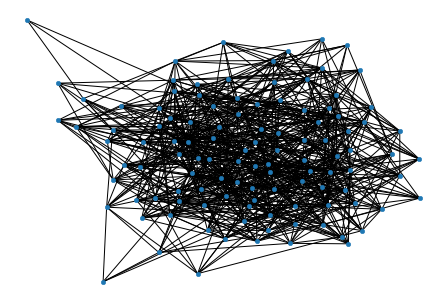

In [23]:
nx.draw(G,node_size=20)

## Shows the Graph where the nodes are colored according to their label

In [24]:
features = pd.Series(Y.invested) # invested or inv_pref

In [25]:
features.unique()

array([1, 0])

In [26]:
legend = features.to_dict()

In [27]:
color_map = []
for i in features.items():
    if i[1] == 0:
        color_map.append('red')
    elif i[1] == 1:
        color_map.append('blue')
    elif i[1] == 2:
        color_map.append('yellow')
    elif i[1] == 3:
        color_map.append('pink')
    else:
        color_map.append('purple')

In [28]:
pos = nx.spring_layout(G)

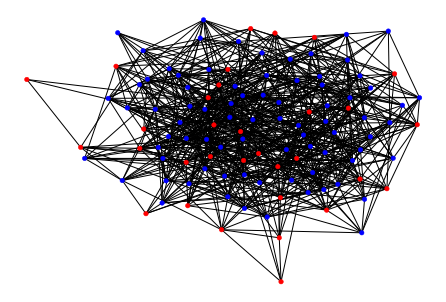

In [29]:
nx.draw(G,pos,labels=features,node_size=20,node_color=color_map,with_labels=False)
plt.show()

## Generate a dgl graph with the feature and label data

In [30]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

G_dgl = dgl.from_networkx(G)
feat = X.drop(columns=['att1','att2','att3','fink1','fink2','fink3','fink4','fink5','fink6','fink7'])

embedding = torch.tensor(feat.values,dtype=torch.float)

G_dgl.ndata['feat'] =  embedding
# assign training nodes
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.4)
# assign the label
G_dgl.ndata['label'] = torch.tensor(features)

Using backend: pytorch


In [31]:
feat

,age,gender,education,employment,income,fink,att
0,1,0,2,3,1,5,8
1,0,1,2,3,0,4,8
2,0,0,3,3,0,5,11
3,1,0,1,1,5,5,8
4,1,0,2,3,0,5,9
...,...,...,...,...,...,...,...
107,1,0,2,0,0,5,11
108,1,1,2,1,2,1,9
109,1,1,2,0,0,6,8
110,4,1,0,2,0,4,9


In [32]:
# assign validation nodes
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

## Define the GraphSage model

In [33]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        #h = F.normalize(h, p=2, dim=1)
        h = F.relu(h)
        h = self.conv2(graph, h)
        #h = F.normalize(h, p=2, dim=1)
        #h = F.softmax(h,dim=1)
        return h

In [34]:
# Evaluate validation data
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [35]:
# Assign the model variables 
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Train the GraphSage Model and get the Results

In [36]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(250):
    t0 = time.time()
    model.train()
    # forward propagation by using all nodes
    logits = model(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
    plot_loss_train.append(loss_train.item())
    plot_loss_val.append(loss_val.item())
    # compute validation accuracy
    acc_val = evaluate(model, G_dgl, node_features, node_labels, valid_mask)
    acc_train = evaluate(model, G_dgl, node_features, node_labels, train_mask)
    valid_acc.append(acc_val)
    train_acc.append(acc_train)
    # backward propagation
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 7.2579, validation loss: 5.1354, training accuracy: 0.1562, validation accuracy: 0.3375, Time: 0.0377
Epoch: 10, train loss: 0.6161, validation loss: 0.7854, training accuracy: 0.7500, validation accuracy: 0.6500, Time: 0.0299
Epoch: 20, train loss: 0.8529, validation loss: 1.9779, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0281
Epoch: 30, train loss: 0.7491, validation loss: 1.8229, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0270
Epoch: 40, train loss: 0.4466, validation loss: 1.0940, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0242
Epoch: 50, train loss: 0.4122, validation loss: 0.7048, training accuracy: 0.8125, validation accuracy: 0.6875, Time: 0.0214
Epoch: 60, train loss: 0.3422, validation loss: 0.7968, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0192
Epoch: 70, train loss: 0.3144, validation loss: 0.8715, training accuracy: 0.9062, validation accuracy: 0.6500, Time: 0.0176
E

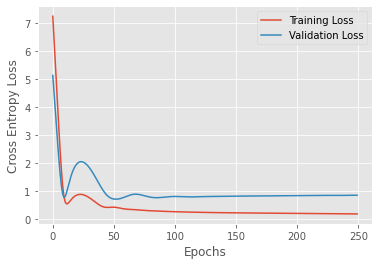

In [37]:
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

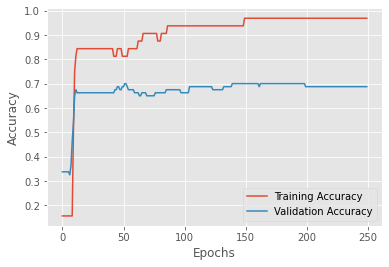

In [38]:
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.6875
-------------------------------------------------------------
Classification Accuracy training set 0.96875
-------------------------------------------------------------
Confusion Matrix validation set:
[[ 3 24]
 [ 1 52]]
-------------------------------------------------------------
Confusion Matrix training set:
[[ 4  1]
 [ 0 27]]


## The Graph Convolutional Network is Defined and Trained Below

In [40]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats)

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        h = F.log_softmax(h,dim=1)
        return h

In [41]:
model = GCN(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(200):
    t0 = time.time()
    model.train()
    # forward propagation by using all nodes
    logits = model(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
    plot_loss_train.append(loss_train.item())
    plot_loss_val.append(loss_val.item())
    # compute validation accuracy
    acc_val = evaluate(model, G_dgl, node_features, node_labels, valid_mask)
    acc_train = evaluate(model, G_dgl, node_features, node_labels, train_mask)
    valid_acc.append(acc_val)
    train_acc.append(acc_train)
    # backward propagation
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.6866, validation loss: 1.5823, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0191
Epoch: 10, train loss: 0.4157, validation loss: 0.7571, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0145
Epoch: 20, train loss: 0.4183, validation loss: 0.6826, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0142
Epoch: 30, train loss: 0.4112, validation loss: 0.8044, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0133
Epoch: 40, train loss: 0.4018, validation loss: 0.7159, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0127
Epoch: 50, train loss: 0.3978, validation loss: 0.7258, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0130
Epoch: 60, train loss: 0.3943, validation loss: 0.7373, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0129
Epoch: 70, train loss: 0.3904, validation loss: 0.7170, training accuracy: 0.8438, validation accuracy: 0.6625, Time: 0.0127
E

In [64]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

roc_auc_score(val_lab,indices_val)

0.5461215932914046

## Below the Node2Vec Algorithm is Implemented

In [65]:
#from node2vec import Node2Vec

#node2vec = Node2Vec(G, dimensions=2, walk_length=5, num_walks=100, workers=1)
#model = node2vec.fit(window=5, min_count=1, batch_words=2)
#model.wv.save_word2vec_format('embeddings')

Computing transition probabilities:   0%|          | 0/112 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


The saved embeddings are loaded below. Not that the above code block only needs to be executed once. The saved embeddings are then directly loaded below. Note, that the first line in the embeddings file must be deleted. Otherwise the file cannot be read.

In [67]:
t = pd.read_csv('embeddings', delimiter = " ", index_col=0, header = None)
t.sort_index(inplace=True)
t = t.to_numpy()
t.shape

(112, 2)

## Downstream Machnine Learning

### Logistic Regression

In [68]:
import statsmodels.api as sm

log_reg = sm.Logit(features, t).fit()

Optimization terminated successfully.
         Current function value: 0.603059
         Iterations 5


In [69]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               invested   No. Observations:                  112
Model:                          Logit   Df Residuals:                      110
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Jul 2021   Pseudo R-squ.:               -0.008006
Time:                        15:48:57   Log-Likelihood:                -67.543
converged:                       True   LL-Null:                       -67.006
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7057      0.208      3.392      0.001       0.298       1.113
x2             0.2031      0.331      0.613      0.540      -0.446       0.852


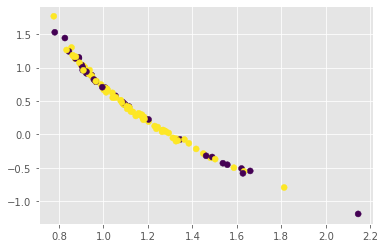

In [70]:
plt.scatter(t[:,0],t[:,1],c=features,label=features)
plt.show()

### ANN

In [48]:
from sklearn.model_selection import train_test_split
f = pd.get_dummies(features)
x_train, x_test, y_train, y_test = train_test_split(X,f, test_size = 0.6, shuffle=True)

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model = Sequential()

model.add(Dense(15, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=150, batch_size=1)

Epoch 1/150
44/44 [==============================] - 3s 39ms/step - loss: 0.6713 - accuracy: 0.6932 - val_loss: 0.6480 - val_accuracy: 0.7206
Epoch 2/150
44/44 [==============================] - 0s 7ms/step - loss: 0.5881 - accuracy: 0.7075 - val_loss: 0.6323 - val_accuracy: 0.7206
Epoch 3/150
44/44 [==============================] - 0s 10ms/step - loss: 0.7055 - accuracy: 0.5858 - val_loss: 0.6254 - val_accuracy: 0.7206
Epoch 4/150
44/44 [==============================] - 0s 7ms/step - loss: 0.6791 - accuracy: 0.6177 - val_loss: 0.6222 - val_accuracy: 0.7206
Epoch 5/150
44/44 [==============================] - 0s 7ms/step - loss: 0.5977 - accuracy: 0.6722 - val_loss: 0.6152 - val_accuracy: 0.7206
Epoch 6/150
44/44 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.6544 - val_loss: 0.6168 - val_accuracy: 0.7206
Epoch 7/150
44/44 [==============================] - 0s 5ms/step - loss: 0.5529 - accuracy: 0.7330 - val_loss: 0.6155 - val_accuracy: 0.7206
Epoch 8/150

Epoch 59/150
44/44 [==============================] - 0s 6ms/step - loss: 0.3157 - accuracy: 0.8887 - val_loss: 0.5726 - val_accuracy: 0.7500
Epoch 60/150
44/44 [==============================] - 0s 7ms/step - loss: 0.2340 - accuracy: 0.8989 - val_loss: 0.6760 - val_accuracy: 0.6029
Epoch 61/150
44/44 [==============================] - 0s 6ms/step - loss: 0.2559 - accuracy: 0.9779 - val_loss: 0.6133 - val_accuracy: 0.7647
Epoch 62/150
44/44 [==============================] - 0s 4ms/step - loss: 0.2705 - accuracy: 0.9418 - val_loss: 0.6420 - val_accuracy: 0.7206
Epoch 63/150
44/44 [==============================] - 0s 6ms/step - loss: 0.2413 - accuracy: 0.9353 - val_loss: 0.6066 - val_accuracy: 0.7353
Epoch 64/150
44/44 [==============================] - 0s 4ms/step - loss: 0.2107 - accuracy: 0.9364 - val_loss: 0.6475 - val_accuracy: 0.7059
Epoch 65/150
44/44 [==============================] - 0s 5ms/step - loss: 0.3274 - accuracy: 0.8903 - val_loss: 0.6166 - val_accuracy: 0.7353
Epoch 

44/44 [==============================] - 0s 6ms/step - loss: 0.0988 - accuracy: 1.0000 - val_loss: 0.8862 - val_accuracy: 0.6324
Epoch 117/150
44/44 [==============================] - 0s 6ms/step - loss: 0.0789 - accuracy: 1.0000 - val_loss: 0.9187 - val_accuracy: 0.6324
Epoch 118/150
44/44 [==============================] - 0s 6ms/step - loss: 0.0904 - accuracy: 0.9945 - val_loss: 0.9308 - val_accuracy: 0.6324
Epoch 119/150
44/44 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.9968 - val_loss: 0.8802 - val_accuracy: 0.6324
Epoch 120/150
44/44 [==============================] - 0s 4ms/step - loss: 0.1068 - accuracy: 1.0000 - val_loss: 0.9425 - val_accuracy: 0.6176
Epoch 121/150
44/44 [==============================] - 0s 6ms/step - loss: 0.0649 - accuracy: 1.0000 - val_loss: 0.9406 - val_accuracy: 0.6324
Epoch 122/150
44/44 [==============================] - 0s 7ms/step - loss: 0.0663 - accuracy: 0.9951 - val_loss: 0.9483 - val_accuracy: 0.6176
Epoch 123/150

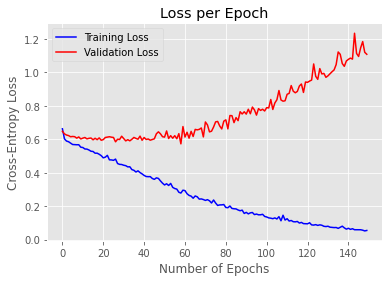

In [50]:
plt.plot(history.history['loss'],label = 'Training Loss', color = 'blue')
plt.plot(history.history['val_loss'],label = 'Validation Loss', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

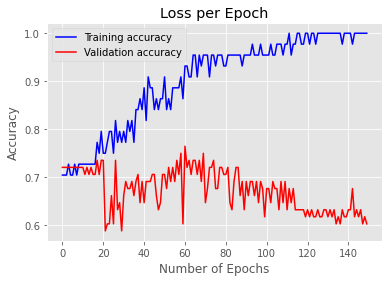

In [51]:
plt.plot(history.history['accuracy'],label = 'Training accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy', color = 'red')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

## Graph Theoretical Measures

Below the graph theoretical measures such as the density, degree distribution and the centralities are calculated

In [71]:
nx.classes.function.density(G)

0.12676962676962678

In [54]:
cent = nx.algorithms.centrality.eigenvector_centrality(G)
clos_cent = nx.algorithms.centrality.closeness_centrality(G)
be_cent = nx.algorithms.centrality.betweenness_centrality(G)

In [55]:
obj = cent.items()
l = list(obj)
r = np.array(l)
r = r[:,1]

Text(0, 0.5, 'Number of Nodes')

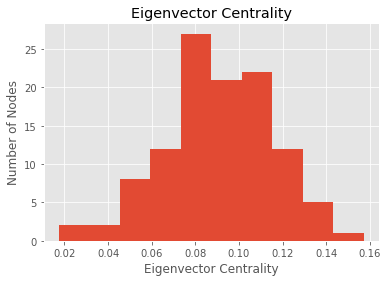

In [56]:
plt.hist(r)
plt.title('Eigenvector Centrality')
plt.xlabel('Eigenvector Centrality')
plt.ylabel('Number of Nodes')

In [57]:
obj = clos_cent.items()
l = list(obj)
r = np.array(l)
r = r[:,1]

Text(0, 0.5, 'Number of Nodes')

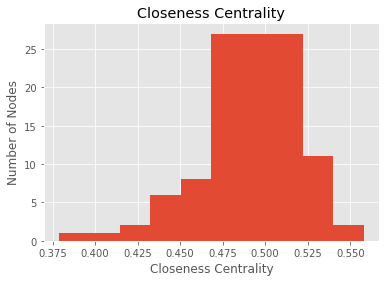

In [58]:
plt.hist(r)
plt.title('Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.ylabel('Number of Nodes')

In [59]:
obj = be_cent.items()
l = list(obj)
r = np.array(l)
r = r[:,1]

Text(0, 0.5, 'Number of Nodes')

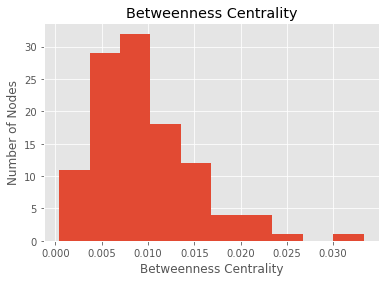

In [60]:
plt.hist(r)
plt.title('Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Number of Nodes')

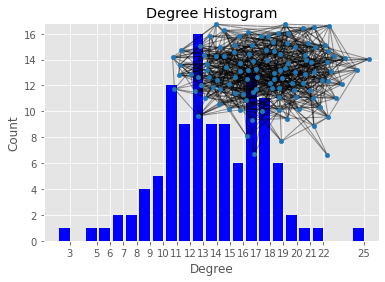

In [61]:
import collections

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(G)
plt.axis("off")
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

In [62]:
nx.algorithms.cluster.average_clustering(G)

0.13777755072093847

In [63]:
G.degree()

DegreeView({0: 22, 1: 12, 2: 17, 3: 10, 4: 13, 5: 11, 6: 18, 7: 13, 8: 14, 9: 13, 10: 18, 11: 20, 12: 13, 13: 11, 14: 15, 15: 18, 16: 14, 17: 13, 18: 12, 19: 8, 20: 12, 21: 15, 22: 14, 23: 18, 24: 20, 25: 19, 26: 13, 27: 19, 28: 13, 29: 17, 30: 15, 31: 17, 32: 11, 33: 5, 34: 14, 35: 12, 36: 12, 37: 11, 38: 9, 39: 13, 40: 14, 41: 13, 42: 14, 43: 14, 44: 16, 45: 17, 46: 15, 47: 16, 48: 12, 49: 21, 50: 17, 51: 19, 52: 19, 53: 6, 54: 10, 55: 18, 56: 11, 57: 25, 58: 10, 59: 13, 60: 7, 61: 16, 62: 9, 63: 19, 64: 13, 65: 18, 66: 17, 67: 17, 68: 15, 69: 17, 70: 11, 71: 17, 72: 9, 73: 12, 74: 16, 75: 10, 76: 17, 77: 12, 78: 7, 79: 18, 80: 15, 81: 15, 82: 16, 83: 17, 84: 12, 85: 8, 86: 11, 87: 10, 88: 11, 89: 18, 90: 11, 91: 15, 92: 16, 93: 11, 94: 18, 95: 9, 96: 17, 97: 18, 98: 13, 99: 15, 100: 13, 101: 11, 102: 14, 103: 13, 104: 11, 105: 13, 106: 14, 107: 18, 108: 19, 109: 13, 110: 3, 111: 17})